In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Attention, Multiply
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.schedules import ExponentialDecay


from sklearn.metrics import mean_squared_error,root_mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/googl_data_2020_2025.csv')
df.head()

,Price,Adj Close,Close,High,Low,Open,Volume
0,Ticker,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL
1,Date,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-02 00:00:00+00:00,68.18682098,68.43399811,68.43399811,67.32450104,67.42050171,27278000
3,2020-01-03 00:00:00+00:00,67.83010101,68.0759964,68.6875,67.36599731,67.40000153,23408000
4,2020-01-06 00:00:00+00:00,69.63805389,69.89050293,69.91600037,67.55000305,67.58149719,46768000


In [4]:
df = df.iloc[2:,:]
df.head()

,Price,Adj Close,Close,High,Low,Open,Volume
2,2020-01-02 00:00:00+00:00,68.18682098,68.43399811,68.43399811,67.32450104,67.42050171,27278000
3,2020-01-03 00:00:00+00:00,67.83010101,68.0759964,68.6875,67.36599731,67.40000153,23408000
4,2020-01-06 00:00:00+00:00,69.63805389,69.89050293,69.91600037,67.55000305,67.58149719,46768000
5,2020-01-07 00:00:00+00:00,69.50354767,69.75550079,70.17500305,69.57800293,70.02300262,34330000
6,2020-01-08 00:00:00+00:00,69.99825287,70.2519989,70.59249878,69.63150024,69.74099731,35314000


In [5]:
df.rename(columns={'Price':'Date'},inplace=True)
df.head()

,Date,Adj Close,Close,High,Low,Open,Volume
2,2020-01-02 00:00:00+00:00,68.18682098,68.43399811,68.43399811,67.32450104,67.42050171,27278000
3,2020-01-03 00:00:00+00:00,67.83010101,68.0759964,68.6875,67.36599731,67.40000153,23408000
4,2020-01-06 00:00:00+00:00,69.63805389,69.89050293,69.91600037,67.55000305,67.58149719,46768000
5,2020-01-07 00:00:00+00:00,69.50354767,69.75550079,70.17500305,69.57800293,70.02300262,34330000
6,2020-01-08 00:00:00+00:00,69.99825287,70.2519989,70.59249878,69.63150024,69.74099731,35314000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 2 to 1259
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Date       1258 non-null   object
 1   Adj Close  1258 non-null   object
 2   Close      1258 non-null   object
 3   High       1258 non-null   object
 4   Low        1258 non-null   object
 5   Open       1258 non-null   object
 6   Volume     1258 non-null   object
dtypes: object(7)
memory usage: 68.9+ KB


In [7]:
for col in df.drop(columns='Date'):
  df[col] = df[col].astype(float)

In [8]:
round(df.describe(),2).T

,count,mean,std,min,25%,50%,75%,max
Adj Close,1258.0,118.68,32.40,52.52,93.61,119.27,140.60,1.966600e+02
Close,1258.0,119.08,32.45,52.71,93.95,119.70,141.11,1.966600e+02
High,1258.0,120.38,32.69,53.35,95.27,121.04,142.10,2.014200e+02
Low,1258.0,117.72,32.25,50.44,92.31,118.63,139.80,1.949800e+02
Open,1258.0,119.00,32.48,52.82,93.83,119.71,141.00,1.972500e+02
Volume,1258.0,33087950.56,14617583.24,9312000.00,23439375.00,29433000.00,37735150.00,1.232000e+08


In [9]:
df.isnull().sum()

,0
Date,0
Adj Close,0
Close,0
High,0
Low,0
Open,0
Volume,0


In [10]:
df['Date'] = pd.to_datetime(df['Date'])
df.head(2)

,Date,Adj Close,Close,High,Low,Open,Volume
2,2020-01-02 00:00:00+00:00,68.186821,68.433998,68.433998,67.324501,67.420502,27278000.0
3,2020-01-03 00:00:00+00:00,67.830101,68.075996,68.687500,67.365997,67.400002,23408000.0


In [11]:
df['Date'] = df['Date'].dt.date
df.head(2)

,Date,Adj Close,Close,High,Low,Open,Volume
2,2020-01-02,68.186821,68.433998,68.433998,67.324501,67.420502,27278000.0
3,2020-01-03,67.830101,68.075996,68.687500,67.365997,67.400002,23408000.0


In [12]:
df.tail()

,Date,Adj Close,Close,High,Low,Open,Volume
1255,2024-12-24,196.110001,196.110001,196.110001,193.779999,194.839996,10403300.0
1256,2024-12-26,195.600006,195.600006,196.750000,194.380005,195.149994,12046600.0
1257,2024-12-27,192.759995,192.759995,195.320007,190.649994,194.949997,18891400.0
1258,2024-12-30,191.240005,191.240005,192.550003,189.119995,189.800003,14264700.0
1259,2024-12-31,189.300003,189.300003,191.960007,188.509995,191.080002,17466900.0


In [13]:
df.set_index('Date',inplace=True)
df.head()

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2020-01-02,68.186821,68.433998,68.433998,67.324501,67.420502,27278000.0
2020-01-03,67.830101,68.075996,68.687500,67.365997,67.400002,23408000.0
2020-01-06,69.638054,69.890503,69.916000,67.550003,67.581497,46768000.0
2020-01-07,69.503548,69.755501,70.175003,69.578003,70.023003,34330000.0
2020-01-08,69.998253,70.251999,70.592499,69.631500,69.740997,35314000.0


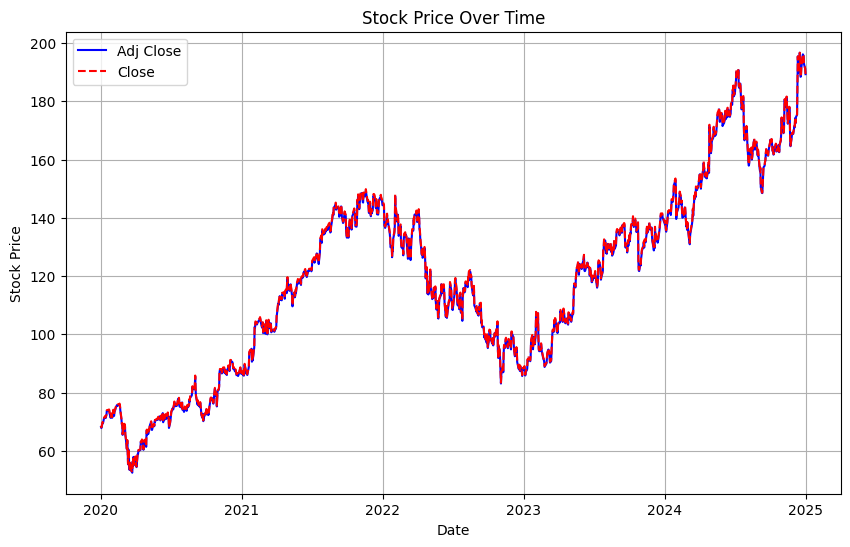

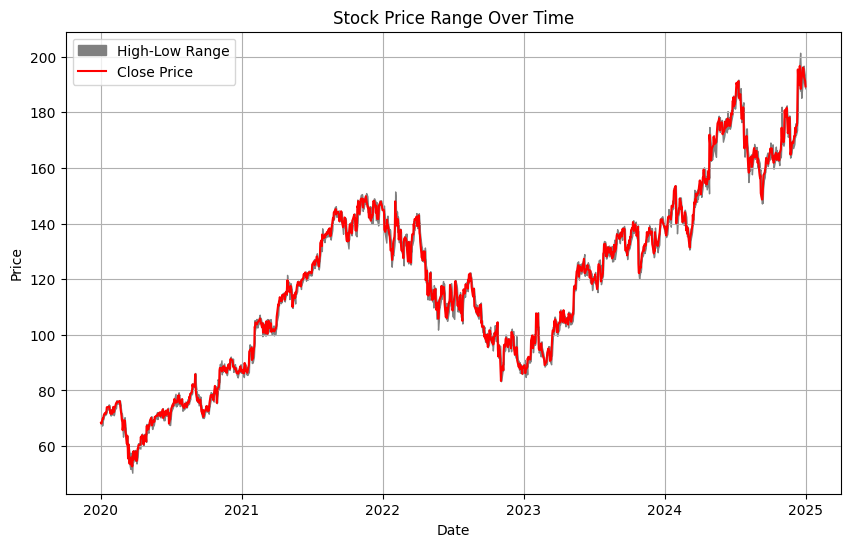

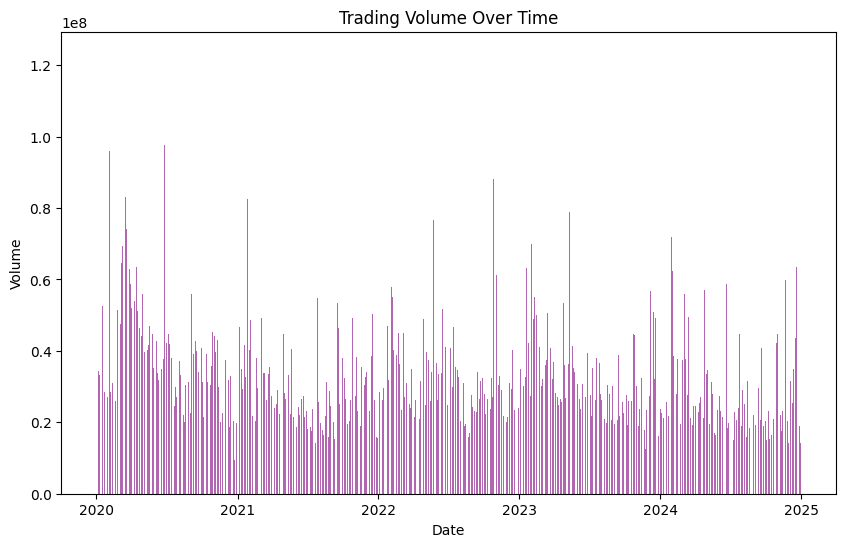

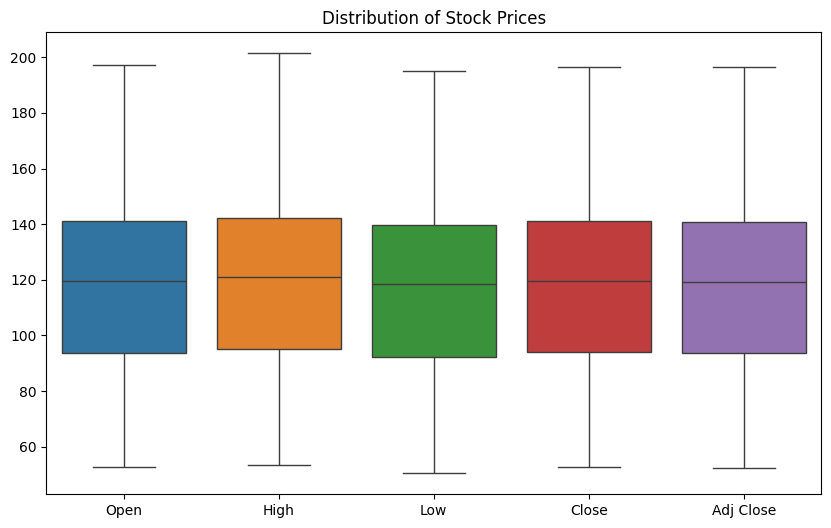

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Adj Close'], label='Adj Close', color='blue')
plt.plot(df.index, df['Close'], label='Close', color='red', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Over Time')
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(10, 6))
plt.fill_between(df.index, df['High'], df['Low'], color='gray', label='High-Low Range')
plt.plot(df.index, df['Close'], color='red', label='Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Price Range Over Time')
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(10,6))
plt.bar(df.index, df['Volume'], color='purple', alpha=0.6)
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('Trading Volume Over Time')
plt.show()


plt.figure(figsize=(10,6))
sns.boxplot(data=df[['Open', 'High', 'Low', 'Close', 'Adj Close']])
plt.title('Distribution of Stock Prices')
plt.show()

In [15]:
# Define moving average windows
sma_windows = [7, 30, 365]
ema_windows = [7, 30, 365]

# Calculate Simple Moving Averages (SMA)
for window in sma_windows:
    df[f"SMA_{window}"] = df["Adj Close"].rolling(window=window).mean()

# Calculate Exponential Moving Averages (EMA)
for window in ema_windows:
    df[f"EMA_{window}"] = df["Adj Close"].ewm(span=window, adjust=False).mean()

# Drop NaN values (first rows where MA couldn't be calculated)
df = df.dropna()

In [16]:
df.shape

(894, 12)

In [17]:
df.head()

,Adj Close,Close,High,Low,Open,Volume,SMA_7,SMA_30,SMA_365,EMA_7,EMA_30,EMA_365
Date,,,,,,,,,,,,
2021-06-14,122.003227,122.445503,122.445999,120.900002,121.612999,22098000.0,120.395627,116.555809,83.602284,120.436272,116.988736,89.605540
2021-06-15,120.980934,121.419502,122.775497,121.056000,122.449997,21562000.0,120.643442,116.697479,83.746926,120.572438,117.246297,89.776990
2021-06-16,120.336266,120.772499,121.886002,119.470001,121.571999,26472000.0,120.737032,116.877858,83.890778,120.513395,117.445650,89.943980
2021-06-17,121.303764,121.743500,122.522499,120.500000,120.697502,25842000.0,120.996307,117.077302,84.032328,120.710987,117.694560,90.115345
2021-06-18,119.677162,120.111000,121.602997,120.014999,121.366997,46116000.0,120.955597,117.185028,84.169790,120.452531,117.822470,90.276885


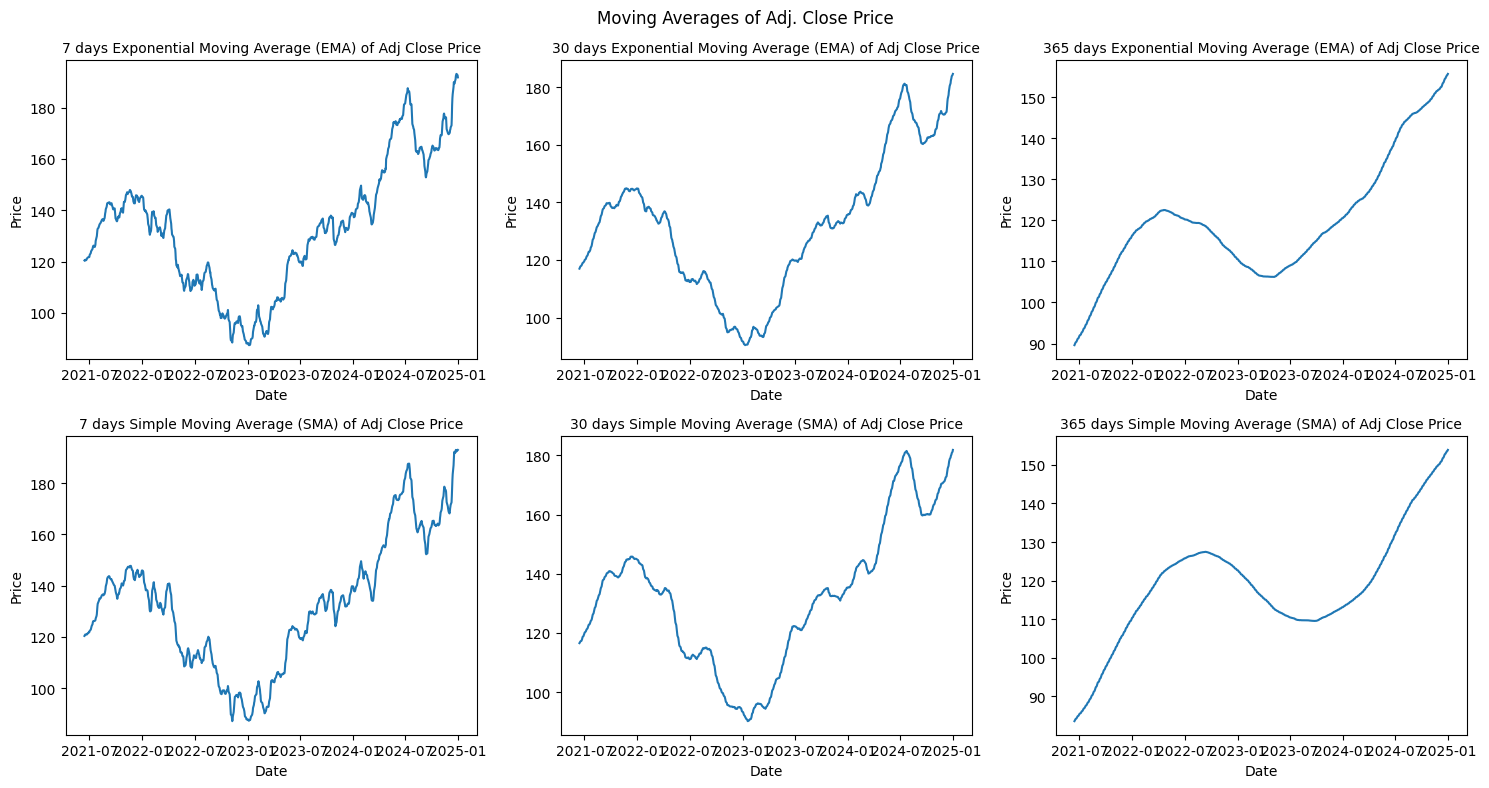

In [18]:
plt.figure(figsize=[15,8])
plt.suptitle('Moving Averages of Adj. Close Price')
plt.subplot(2,3,1)
df['EMA_7'].plot()
plt.title('7 days Exponential Moving Average (EMA) of Adj Close Price',fontdict={'fontsize':10})
plt.xlabel('Date')
plt.ylabel('Price')

plt.subplot(2,3,2)
df['EMA_30'].plot()
plt.title('30 days Exponential Moving Average (EMA) of Adj Close Price',fontdict={'fontsize':10})
plt.xlabel('Date')
plt.ylabel('Price')

plt.subplot(2,3,3)
df['EMA_365'].plot()
plt.title('365 days Exponential Moving Average (EMA) of Adj Close Price',fontdict={'fontsize':10})
plt.xlabel('Date')
plt.ylabel('Price')

plt.subplot(2,3,4)
df['SMA_7'].plot()
plt.title('7 days Simple Moving Average (SMA) of Adj Close Price',fontdict={'fontsize':10})
plt.xlabel('Date')
plt.ylabel('Price')


plt.subplot(2,3,5)
df['SMA_30'].plot()
plt.title('30 days Simple Moving Average (SMA) of Adj Close Price',fontdict={'fontsize':10})
plt.xlabel('Date')


plt.subplot(2,3,6)
df['SMA_365'].plot()
plt.title('365 days Simple Moving Average (SMA) of Adj Close Price',fontdict={'fontsize':10})
plt.xlabel('Date')
plt.ylabel('Price')


plt.tight_layout()
plt.show()



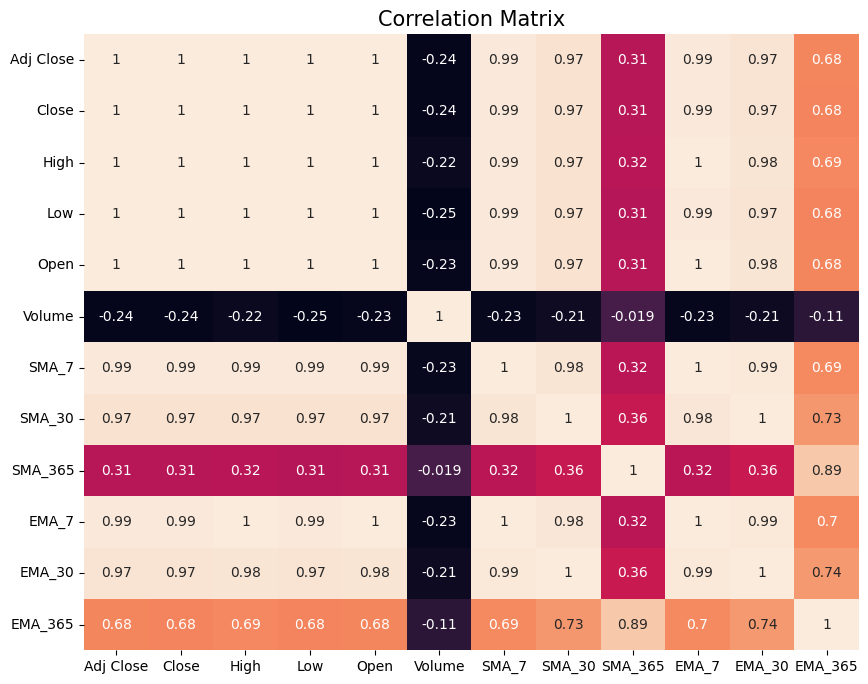

In [19]:
plt.figure(figsize=(10,8))
plt.title("Correlation Matrix",fontdict={'fontsize':15})
sns.heatmap(df.corr(),annot=True,cbar=False)
plt.show()

In [20]:
# Removing SMA_265 column because it is less correlated to the target column.
df.drop(columns=['SMA_365'],inplace=True)

## Model Building

Target columns: Adj Close<br>
Features: Close,	High,	Low,	Open,	Volume,	SMA_7,	SMA_30,	EMA_7, EMA_30, EMA_365

In [21]:
# Separate scalers for features and target
ss_X = MinMaxScaler()
ss_y = MinMaxScaler()

# Fit the scalers
df_features_scaled = ss_X.fit_transform(df.drop(columns=["Adj Close"]))
df_target_scaled = ss_y.fit_transform(df[["Adj Close"]])

def create_sequences(data_X, data_y, time_steps=60):
    X, y = [], []
    for i in range(len(data_X) - time_steps):
        X.append(data_X[i:i + time_steps])  # Features
        y.append(data_y[i + time_steps])    # Target column
    return np.array(X), np.array(y)

# Create sequences
time_steps = 100
X, y = create_sequences(df_features_scaled, df_target_scaled, time_steps)

# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=0)

# Print shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (635, 100, 10), y_train shape: (635, 1)
X_test shape: (159, 100, 10), y_test shape: (159, 1)


In [30]:
# Build LSTM + Attention Model
tf.random.set_seed(1)
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
lstm_out = LSTM(128, return_sequences=True,kernel_regularizer=l2(0.01))(inputs)
dropout_out = Dropout(0.3)(lstm_out)

# Attention Layer
attention = Attention()([lstm_out, lstm_out])
context_vector = Multiply()([attention, lstm_out])

# LSTM Layer after Attention
lstm_out = LSTM(128, return_sequences=False)(context_vector)
dropout_out = Dropout(0.4)(lstm_out)
output = Dense(1)(dropout_out)

model = Model(inputs, output)
model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")

In [31]:
# Callbacks
early_stop = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-5)

# Train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32,
          verbose=1, callbacks=[early_stop, lr_scheduler])

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 429ms/step - loss: 0.2503 - val_loss: 0.1486 - learning_rate: 0.0010
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 308ms/step - loss: 0.1202 - val_loss: 0.0858 - learning_rate: 0.0010
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 304ms/step - loss: 0.0747 - val_loss: 0.0595 - learning_rate: 0.0010
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 458ms/step - loss: 0.0477 - val_loss: 0.0370 - learning_rate: 0.0010
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 297ms/step - loss: 0.0324 - val_loss: 0.0268 - learning_rate: 0.0010
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 302ms/step - loss: 0.0239 - val_loss: 0.0208 - learning_rate: 0.0010
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 355ms/step - loss: 0.0188 - val_loss: 0.0181 - learning_rate: 0.0010
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 300ms/step - loss: 0.0153 - val_loss: 0.0157 - learning_rate: 0.0010
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 292ms/step - loss: 0.0135 - val_loss: 0.0192 - learning_rate: 0.00

In [32]:
# Predictions
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


In [33]:
# Inverse transform predictions and actual values
train_preds_inv = ss_y.inverse_transform(train_preds)
test_preds_inv = ss_y.inverse_transform(test_preds)
y_train_inv = ss_y.inverse_transform(y_train)
y_test_inv = ss_y.inverse_transform(y_test)

# Evaluate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train_inv, train_preds_inv))
test_rmse = np.sqrt(mean_squared_error(y_test_inv, test_preds_inv))

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train RMSE: 5.514317755150989
Test RMSE: 8.414564010299648


In [34]:
mean_price = np.mean(ss_y.inverse_transform(y_test))  # Mean actual price
percentage_error = (test_rmse / mean_price) * 100
print(f"Test RMSE as percentage of mean price: {percentage_error:.2f}%")

Test RMSE as percentage of mean price: 4.89%


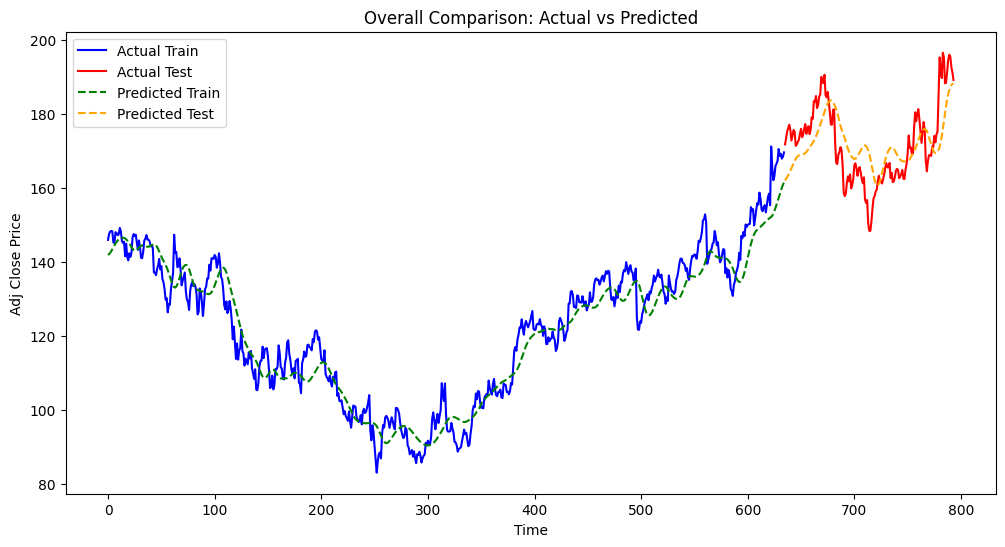

In [35]:
# Plot Full Data Comparison
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_train_inv)), y_train_inv, label="Actual Train", color="blue")
plt.plot(range(len(y_train_inv), len(y_train_inv) + len(y_test_inv)), y_test_inv, label="Actual Test", color="red")
plt.plot(range(len(y_train_inv)), train_preds_inv, label="Predicted Train", color="green", linestyle="dashed")
plt.plot(range(len(y_train_inv), len(y_train_inv) + len(y_test_inv)), test_preds_inv, label="Predicted Test", color="orange", linestyle="dashed")
plt.title("Overall Comparison: Actual vs Predicted")
plt.xlabel("Time")
plt.ylabel("Adj Close Price")
plt.legend()
plt.show()

In [36]:
# Get the last 100 days from the dataset (scaled)
future_input = X_test[-1]  # Last sequence from test data
future_predictions = []

# Predict the next 30 days
for _ in range(30):
    next_pred = model.predict(future_input.reshape(1, future_input.shape[0], future_input.shape[1]))  # Reshape for model input
    future_predictions.append(next_pred[0, 0])  # Store single predicted value

    # Shift the input sequence left and add the new prediction
    future_input = np.roll(future_input, shift=-1, axis=0)  # Shift left
    future_input[-1, -1] = next_pred  # Insert the predicted value at the last position

# Convert predictions back to original scale
future_predictions_inv = ss_y.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Generate future dates for visualization
last_date = df.index[-1]  # Get last date in dataset
future_dates = pd.date_range(start=last_date, periods=31, freq='B')[1:]  # Next 30 business days

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━

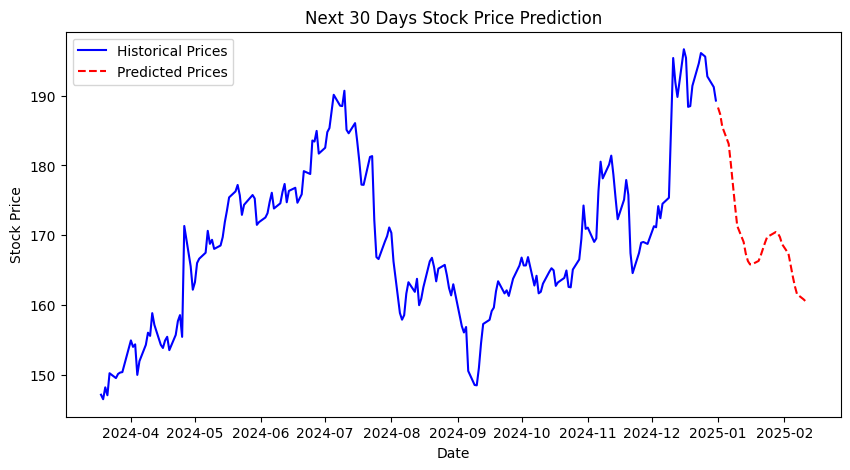

Predicted Prices for the Next 30 Days:
[188.30498 187.36421 185.54315 183.09366 180.25932 177.18819 174.12952
 171.33691 169.03633 167.3643  166.30333 165.81859 165.84807 166.31682
 167.09401 168.00946 168.92415 169.7373  170.268   170.4559  170.30522
 169.73807 168.72643 167.35443 165.74785 164.13026 162.68852 161.55727
 160.8344  160.54529]


In [37]:
# Plot results
plt.figure(figsize=(10, 5))
plt.plot(df.index[-200:], df["Adj Close"].iloc[-200:], label="Historical Prices", color='blue')
plt.plot(future_dates, future_predictions_inv, label="Predicted Prices", color='red', linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Next 30 Days Stock Price Prediction")
plt.legend()
plt.show()

# Print predicted prices
print("Predicted Prices for the Next 30 Days:")
print(future_predictions_inv.flatten())